In [1]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

In [2]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS = 3

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "dataset",
    shuffle = True,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 6862 files belonging to 11 classes.


In [4]:
class_names = dataset.class_names

In [5]:
class_names

['dew',
 'fogsmog',
 'frost',
 'glaze',
 'hail',
 'lightning',
 'rain',
 'rainbow',
 'rime',
 'sandstorm',
 'snow']

In [6]:
CLASSES = ['dew',
 'fogsmog',
 'frost',
 'glaze',
 'hail',
 'lightning',
 'rain',
 'rainbow',
 'rime',
 'sandstorm',
 'snow']

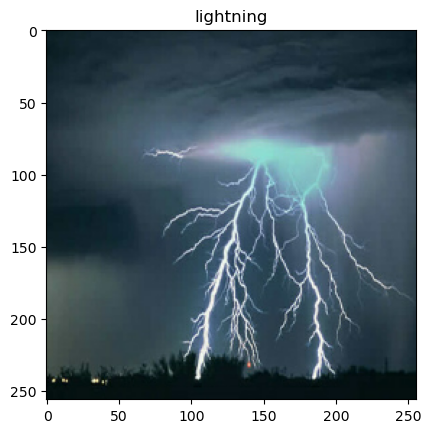

In [7]:
for image_batch, label_batch in dataset.take(1):
    plt.imshow(image_batch[0].numpy().astype('uint8'))
    plt.title(class_names[label_batch[0]])
    plt.show()

In [8]:
len(dataset)

215

In [9]:
train_data = dataset.take(int(len(dataset) * 0.8))
len(train_data)

172

In [10]:
test_ds = dataset.skip(172)

In [11]:
val_size = 0.1
val_data = test_ds.take(17)

In [12]:
test_data = test_ds.skip(17)

In [13]:
def get_partition(dataset, train_split = 0.8, test_split = 0.1, val_split = 0.1, shuffle = True, shuffle_size = 1000):
    data_size = len(dataset)
    if shuffle:
        dataset = dataset.shuffle(shuffle_size, seed = 12)
    train_size = int(data_size * train_split)
    test_size = int(data_size * test_split)

    train_dataset = dataset.take(train_size)
    test_dataset = dataset.skip(train_size).take(test_size)
    val_dataset = dataset.skip(train_size).take(test_size)

    return train_dataset, test_dataset, val_dataset

In [14]:
train_ds, test_ds, val_ds = get_partition(dataset)

In [15]:
len(train_ds)

172

In [16]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

In [17]:
data_augment = keras.Sequential([
    keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    keras.layers.experimental.preprocessing.RandomRotation(0.2)
])

In [18]:
data_scale = keras.Sequential([
    keras.layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    keras.layers.experimental.preprocessing.Rescaling(1./255)
])

In [19]:
train_ds = train_ds.map(
    lambda x, y: (data_augment(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [20]:
input_shape = (32, 256, 256, 3)

model = keras.Sequential([
    data_scale,
    keras.layers.Conv2D(32, (3, 3), activation = 'relu', input_shape = input_shape),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Conv2D(64, (3, 3), activation = 'relu'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Conv2D(64, (3, 3), activation = 'relu'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Conv2D(64, (3, 3), activation = 'relu'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Conv2D(64, (3, 3), activation = 'relu'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Conv2D(64, (3, 3), activation = 'relu'),
    keras.layers.MaxPooling2D((2, 2)),

    keras.layers.Flatten(),
    keras.layers.Dense(64, activation = 'relu'),
    keras.layers.Dense(11, activation = 'softmax')
])

In [21]:
model.compile(
    optimizer = 'adam',
    loss = keras.losses.SparseCategoricalCrossentropy(from_logits = False),
    metrics = ['accuracy']
)

In [22]:
history = model.fit(train_ds, epochs = 200, batch_size = 32, verbose = 1, validation_data = val_ds)

Epoch 1/200
172/172 [==============================] - 60s 287ms/step - loss: 1.9776 - accuracy: 0.3215 - val_loss: 1.9796 - val_accuracy: 0.3095
Epoch 2/200
172/172 [==============================] - 38s 221ms/step - loss: 1.4776 - accuracy: 0.5009 - val_loss: 1.2642 - val_accuracy: 0.5208
Epoch 3/200
172/172 [==============================] - 39s 224ms/step - loss: 1.2643 - accuracy: 0.5602 - val_loss: 1.1414 - val_accuracy: 0.6042
Epoch 4/200
172/172 [==============================] - 39s 228ms/step - loss: 1.1862 - accuracy: 0.5849 - val_loss: 1.0412 - val_accuracy: 0.6086
Epoch 5/200
172/172 [==============================] - 40s 232ms/step - loss: 1.1084 - accuracy: 0.6127 - val_loss: 1.0244 - val_accuracy: 0.6235
Epoch 6/200
172/172 [==============================] - 41s 236ms/step - loss: 1.0691 - accuracy: 0.6238 - val_loss: 1.0026 - val_accuracy: 0.6488
Epoch 7/200
172/172 [==============================] - 42s 243ms/step - loss: 1.0452 - accuracy: 0.6347 - val_loss: 1.0310 -

In [23]:
scores = model.evaluate(test_ds)

21/21 [==============================] - 32s 73ms/step - loss: 0.4893 - accuracy: 0.8750


In [26]:
def predict(model, img):
    img_arr = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_arr = tf.expand_dims(img_arr, 0)

    predictions = model.predict(img_arr)
    predicted_class = class_names[np.argmax(predictions[0])]
    conf = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, conf

In [28]:
import numpy as np

1/1 [==============================] - 0s 25ms/step


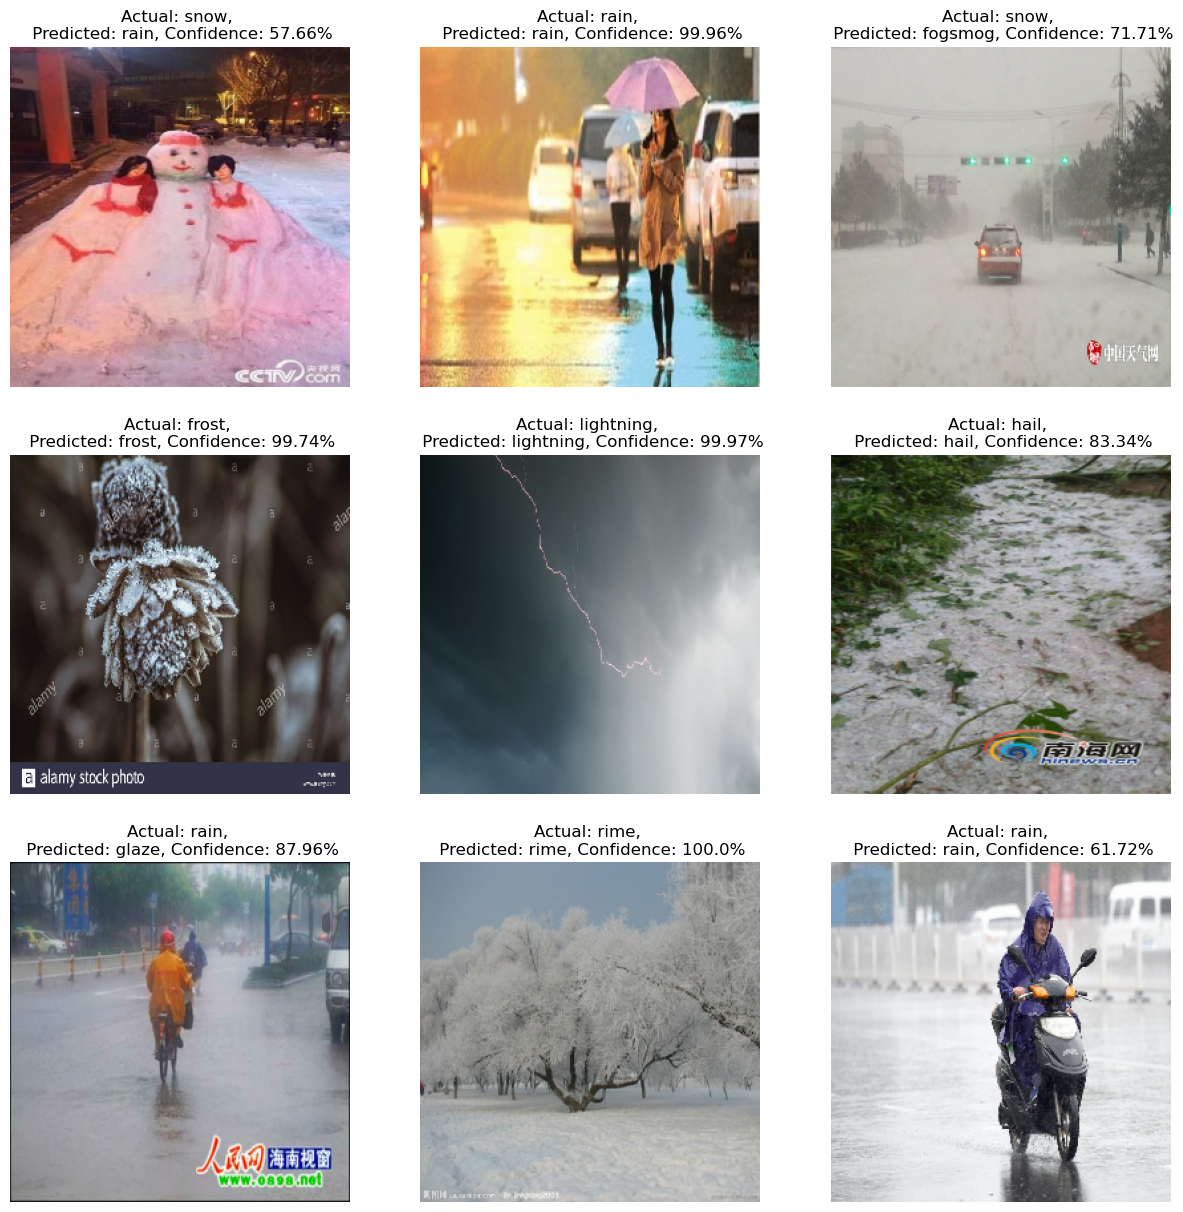

In [29]:
plt.figure(figsize = (15, 15))

for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype('uint8'))

        predicted, conf = predict(model, images[i].numpy())
        act = class_names[labels[i]]

        plt.title(f'Actual: {act}, \n Predicted: {predicted}, Confidence: {conf}%')
        
        plt.axis("off")

In [38]:
import os

model_versions = [i for i in os.listdir("DSC_ANA/weather_prediction/models") if i.isdigit()]

model_version = max([int(i) for i in model_versions] + [0]) + 1

model.save(f"../models/{model_version}")

FileNotFoundError: [WinError 3] The system cannot find the path specified: 'DSC_ANA/weather_prediction/models'

In [ ]:
DSC_ANA/weather_prediction/models